<center><img src = "https://qph.cf2.quoracdn.net/main-qimg-60ee8168e92db44989ea04495fcb171b.webp"></center>

<center><h1>📝 Next Word Prediction 📝</h1></center>

# Loading Libraries

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt

# pickle
import pickle

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# Reading the data

In [2]:
# Get the text file from here :
# https://drive.google.com/file/d/1GeUzNVqiixXHnTl8oNiQ2W3CynX_lsu2/view

file = open("../input/maskiiiii/1661-0.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“', '').replace("”", '')

data = data.split()
data = ' '.join(data)
data[:500]

"Project Gutenberg's The Adventures of Sherlock Holmes, by Arthur Conan Doyle This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.net Title: The Adventures of Sherlock Holmes Author: Arthur Conan Doyle Release Date: November 29, 2002 [EBook #1661] Last Updated: May 20, 2019 Language: English Character set en"

In [3]:
len(data)

573660

# Preprocessing

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[142, 4680, 1, 986, 5, 125, 33, 46, 556, 2164]

In [5]:
len(sequence_data)

108958

In [6]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8624

In [7]:
sequences = []
for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The length of sequences :", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The length of sequences : 108955


array([[ 142, 4680,    1,  986],
       [4680,    1,  986,    5],
       [   1,  986,    5,  125],
       [ 986,    5,  125,   33],
       [   5,  125,   33,   46],
       [ 125,   33,   46,  556],
       [  33,   46,  556, 2164],
       [  46,  556, 2164, 2165],
       [ 556, 2164, 2165,   27],
       [2164, 2165,   27,  987]])

# Train and Test

In [8]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [9]:
print("Data :\n", X[:10])
print()
print("Response :\n", y[:10])

Data :
 [[ 142 4680    1]
 [4680    1  986]
 [   1  986    5]
 [ 986    5  125]
 [   5  125   33]
 [ 125   33   46]
 [  33   46  556]
 [  46  556 2164]
 [ 556 2164 2165]
 [2164 2165   27]]

Response :
 [ 986    5  125   33   46  556 2164 2165   27  987]


In [10]:
y = to_categorical(y, num_classes=vocab_size)
y[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# LSTM

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

2022-06-11 19:10:43.827988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 19:10:43.949734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 19:10:43.950588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 19:10:43.951748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             86240     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 8624)              8632624   
Total params: 21,767,864
Trainable params: 21,767,864
Non-trainable params: 0
_________________________________________________________________


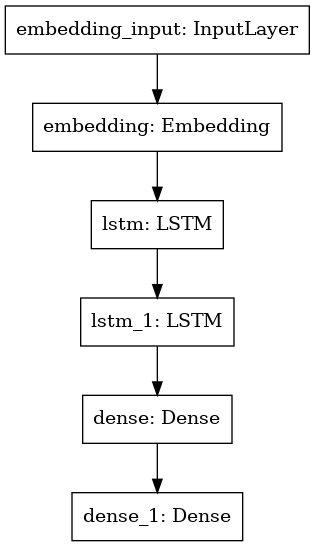

In [13]:
keras.utils.plot_model(model, show_layer_names=True)

# Modeling

In [14]:
checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
lstm = model.fit(X, y, validation_split=0.2, epochs=150, batch_size=128, shuffle=True, callbacks=[checkpoint]).history

2022-06-11 19:10:49.837821: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3006809344 exceeds 10% of free system memory.
2022-06-11 19:10:53.478531: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3006809344 exceeds 10% of free system memory.
2022-06-11 19:10:55.667036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-06-11 19:10:58.758964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


681/681 [==============================] - 18s 19ms/step - loss: 6.5591 - val_loss: 6.5090

Epoch 00001: loss improved from inf to 6.55915, saving model to nextword1.h5
Epoch 2/150
681/681 [==============================] - 11s 16ms/step - loss: 5.9825 - val_loss: 6.2887

Epoch 00002: loss improved from 6.55915 to 5.98251, saving model to nextword1.h5
Epoch 3/150
681/681 [==============================] - 11s 16ms/step - loss: 5.5802 - val_loss: 6.2859

Epoch 00003: loss improved from 5.98251 to 5.58017, saving model to nextword1.h5
Epoch 4/150
681/681 [==============================] - 11s 16ms/step - loss: 5.3007 - val_loss: 6.3310

Epoch 00004: loss improved from 5.58017 to 5.30069, saving model to nextword1.h5
Epoch 5/150
681/681 [==============================] - 11s 16ms/step - loss: 5.0639 - val_loss: 6.4711

Epoch 00005: loss improved from 5.30069 to 5.06389, saving model to nextword1.h5
Epoch 6/150
681/681 [==============================] - 11s 16ms/step - loss: 4.8341 - val_l

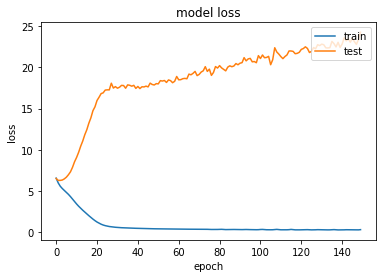

In [15]:
plt.plot(lstm['loss'])
plt.plot(lstm['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# Results

In [16]:
model = load_model("nextword1.h5")
tokenizer = pickle.load(open("tokenizer1.pkl", 'rb'))

In [17]:
def predict_next_words(model, tokenizer, text) :
    
    sequence = tokenizer.texts_to_sequences([text])
    sequence = np.array(sequence)
    
    preds = np.argmax(model.predict(sequence))
    predicted_word = ""
    
    for key, value in tokenizer.word_index.items() :
        if value == preds :
            predicted_word = key
            break
    
    return predicted_word

In [18]:
l = ["The Adventures of", "by Arthur Conan", "it is all", "0"]

for i in l :
    
    text = i
    
    if text == "0" :
        print()
        print("Execution completed...")
        break
    
    else :
        try :
            text = text.split(" ")
            text = text[-3:]
            print("Input :", i)
            print("Output : ", i, predict_next_words(model, tokenizer, text))
            print()
            
        except Exception as e :
            print("Error occured : ", e)
            continue

Input : The Adventures of
Output :  The Adventures of sherlock

Input : by Arthur Conan
Output :  by Arthur Conan doyle

Input : it is all
Output :  it is all right


Execution completed...
